In [2]:
#!pip uninstall mlxtend
#!pip install mlxtend==0.19
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from datetime import datetime
from sklearn.datasets import load_iris
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(mlxtend.__version__)

0.19.0


**Read and clean data**

In [4]:
iris = load_iris()
df = pd.DataFrame(data=np.c_[iris["data"], iris["target"]],
                     columns=iris["feature_names"] + ["target"])

# Inputs: sepal length (cm),	sepal width (cm),	petal length (cm)
X = df[df.columns[0:3]]

# Output (dependent var) - in series format
y = df['petal width (cm)']

**Split into train/test** 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Step forward**

In [6]:
sfs = SFS(RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
          k_features=(1, len(X_train.columns)),
          forward=True,
          floating=False,
          verbose=2,
          cv=4,
          scoring="r2",
          n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished

[2022-08-22 00:17:39] Features: 1/3 -- score: 0.9168824158474809[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s finished

[2022-08-22 00:17:40] Features: 2/3 -- score: 0.922511246744856[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished

[2022-08-22 00:17:42] Features: 3/3 -- score: 0.9359591353205714

In [7]:
print(sfs.k_feature_names_, sfs.k_feature_idx_, sfs.k_score_)
pd.set_option('max_colwidth', 800)
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

('sepal length (cm)', 'sepal width (cm)', 'petal length (cm)') (0, 1, 2) 0.9359591353205714


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)","[0.9585607557507267, 0.9264896181000124, 0.9155693558152211, 0.866909933723963]",0.916882,"(petal length (cm),)",0.05273,0.032895,0.018992
2,"(1, 2)","[0.9447869094074077, 0.9299605745833006, 0.9075452879352417, 0.907752215053474]",0.922511,"(sepal width (cm), petal length (cm))",0.025263,0.01576,0.009099
3,"(0, 1, 2)","[0.9468053907037183, 0.9537838344700843, 0.918087182809389, 0.9251601332990941]",0.935959,"(sepal length (cm), sepal width (cm), petal length (cm))",0.023659,0.01476,0.008521


**Step backward**

In [8]:
sfs = SFS(RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
          k_features=(1, len(X_train.columns)),
          forward=False,
          floating=False,
          verbose=2,
          cv=4,
          scoring="r2",
          n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished

[2022-08-22 00:17:46] Features: 2/1 -- score: 0.922511246744856[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.5s finished

[2022-08-22 00:17:47] Features: 1/1 -- score: 0.9168824158474809

In [9]:
print(sfs.k_feature_names_, sfs.k_feature_idx_, sfs.k_score_)
#pd.set_option('max_colwidth', 800)
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

('sepal length (cm)', 'sepal width (cm)', 'petal length (cm)') (0, 1, 2) 0.9359591353205714


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
3,"(0, 1, 2)","[0.9468053907037183, 0.9537838344700843, 0.918087182809389, 0.9251601332990941]",0.935959,"(sepal length (cm), sepal width (cm), petal length (cm))",0.023659,0.01476,0.008521
2,"(1, 2)","[0.9447869094074077, 0.9299605745833006, 0.9075452879352417, 0.907752215053474]",0.922511,"(sepal width (cm), petal length (cm))",0.025263,0.01576,0.009099
1,"(2,)","[0.9585607557507267, 0.9264896181000124, 0.9155693558152211, 0.866909933723963]",0.916882,"(petal length (cm),)",0.05273,0.032895,0.018992


**Exhaustive**

In [10]:
#WARNING: Can run REALLY long
print(str(datetime.now()))
efs = EFS(RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1),
          min_features=1,
          max_features=len(X_train.columns),
#          verbose=2,
          cv=4,
          scoring="r2",
          n_jobs=-1).fit(X_train, y_train)
print('\n', str(datetime.now()))

2022-08-22 00:17:47.848991


Features: 7/7


 2022-08-22 00:17:53.493227


In [11]:
print(efs.best_feature_names_, efs.best_idx_, efs.best_score_)
#pd.set_option('max_colwidth', 800)
pd.DataFrame.from_dict(efs.get_metric_dict()).T

('sepal length (cm)', 'sepal width (cm)', 'petal length (cm)') (0, 1, 2) 0.9359591353205714


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
0,"(0,)","[0.5694916151022711, 0.5188652992195764, 0.702180331808383, 0.24869411370592776]",0.509808,"(sepal length (cm),)",0.264409,0.164948,0.095233
1,"(1,)","[0.35346655980304187, -0.3449490392815071, -0.2065209400551995, 0.2594386549933867]",0.015359,"(sepal width (cm),)",0.476158,0.297046,0.171499
2,"(2,)","[0.9585607557507269, 0.9264896181000124, 0.9155693558152211, 0.866909933723963]",0.916882,"(petal length (cm),)",0.05273,0.032895,0.018992
3,"(0, 1)","[0.7735965516618359, 0.7639874826783061, 0.8402338202907405, 0.6269140273304672]",0.751183,"(sepal length (cm), sepal width (cm))",0.124268,0.077523,0.044758
4,"(0, 2)","[0.9341395749281388, 0.9261415695350791, 0.8880463723810593, 0.8929603776326278]",0.910322,"(sepal length (cm), petal length (cm))",0.032211,0.020095,0.011602
5,"(1, 2)","[0.9447869094074077, 0.9299605745833006, 0.9075452879352417, 0.907752215053474]",0.922511,"(sepal width (cm), petal length (cm))",0.025263,0.01576,0.009099
6,"(0, 1, 2)","[0.9468053907037183, 0.9537838344700843, 0.918087182809389, 0.9251601332990941]",0.935959,"(sepal length (cm), sepal width (cm), petal length (cm))",0.023659,0.01476,0.008521


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4fcddfdcd0>)

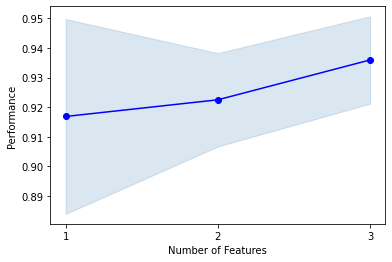

In [12]:
plot_sfs(sfs.get_metric_dict(), kind = "std_dev")

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4fcccf6550>)

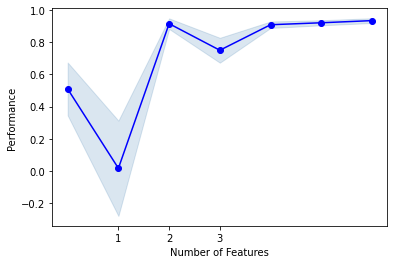

In [13]:
plot_sfs(efs.get_metric_dict(), kind = "std_dev")